# Створення нейронної мережі

У цьому завданні ми створимо повнозв'язну нейронну мережу, використовуючи при цьому низькорівневі механізми tensorflow.

Архітектура нейромережі представлена на наступному малюнку. Як бачиш, у ній є один вхідний шар, два приховані, а також вихідний шар. В якості активаційної функції у прихованих шарах буде використовуватись сигмоїда. На вихідному шарі ми використовуємо softmax.

Частина коду зі створення мережі вже написана, тобі потрібно заповнити пропуски у вказаних місцях.

## Архітектура нейронної мережі

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## Про датасет MNIST

Дану нейромережу ми будемо вивчати на датасеті MNIST. Цей датасет являє собою велику кількість зображень рукописних цифр розміром $28 \times 28$ пікселів. Кожен піксель приймає значення від 0 до 255.

Як і раніше, датасет буде розділений на навчальну та тестову вибірки. При цьому ми виконаємо нормалізацію всіх зображень, щоб значення пікселів знаходилось у проміжку від 0 до 1, розділивши яскравість кожного пікселя на 255.

Окрім того, архітектура нейронної мережі очікує на вхід вектор. У нашому ж випадку кожен об'єкт вибірки являє собою матрицю. Що ж робити? У цьому завданні ми "розтягнемо" матрицю $28 \times 28$, отримавши при цьому вектор, що складається з 784 елементів.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Більше інформації про датасет можна знайти [тут](http://yann.lecun.com/exdb/mnist/).

In [12]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [2]:
num_classes = 10 # загальна кількість класів, у нашому випадку це цифри від 0 до 9
num_features = 784 # кількість атрибутів вхідного вектора 28 * 28 = 784

learning_rate = 0.001 # швидкість навчання нейронної мережі
training_steps = 3000 # максимальне число епох
batch_size = 256 # перераховувати ваги мережі ми будемо не на всій вибірці, а на її випадковій підмножині з batch_size елементів
display_step = 100 # кожні 100 ітерацій ми будемо показувати поточне значення функції втрат і точності

n_hidden_1 = 128 # кількість нейронів 1-го шару
n_hidden_2 = 256 # кількість нейронів 2-го шару

In [3]:
from tensorflow.keras.datasets import mnist

# Завантажуємо датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Перетворюємо цілочисельні пікселі на тип float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)


# Перетворюємо матриці розміром 28x28 пікселів у вектор з 784 елементів
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])


# Нормалізуємо значення пікселів
x_train, x_test = x_train / 255., x_test / 255.


# Перемішаємо тренувальні дані
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

11490434/11490434 [==============================] - 2s 0us/step


In [4]:
# Створимо нейронну мережу

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
          tf.random.normal([in_features, out_features]), name="Weight"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="Bias")

    def __call__(self, x, activation=0):
        y = tf.matmul(x, self.w) + self.b
        if activation != 0:
            return tf.nn.softmax(y)
        else:
            return tf.nn.sigmoid(y)


class NN(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    # Первый слой, состоящий из 128 нейронов
    self.layer_2 = DenseLayer(num_features, n_hidden_1)
    # Второй слой, состоящий из 256 нейронов
    self.layer_3 = DenseLayer(n_hidden_1, n_hidden_2)
    # Выходной слой
    self.out_layer = DenseLayer(n_hidden_2, num_classes)

  def __call__(self, x):
    # Помните что для выхода нейронной сети мы применяем к выходу функцию softmax.
    # Делаем мы это для того, чтобы
    # выход нейронной сети принимал значения от 0 до 1 в соответствии с вероятностью
    # принадлежности входного объекта к одному из 10 классов
    x1 = self.layer_2(x, activation=0)
    x2 = self.layer_3(x1, activation=0)
    x3 = self.out_layer(x2, activation=1)

    return x3

In [5]:
# В якості функції помилки в даному випадку зручно взяти крос-ентропію
def cross_entropy(y_pred, y_true):
    # Encode label to a one hot vector.
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Clip prediction values to avoid log(0) error.
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Обчислення крос-ентропії
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# Як метрику якості використовуємо точність
def accuracy(y_pred, y_true):
    corr_pred = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    return tf.reduce_mean(tf.cast(corr_pred, tf.float32))

In [6]:
# Створимо екземпляр нейронної мережі
neural_net = NN(name="mnist")
optimizer = tf.optimizers.SGD(learning_rate)
# Функция обучения нейросети
def train(nn, input_x, output_y):
  # Для подгонки весов сети будем использовать стохастический градиентный спуск
  # Активация автоматического дифференцирования
  with tf.GradientTape() as g:
    # Модифицируем параметры
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)
    # Создадим оптимизируемых список параметров
    loss_2 = tf.reduce_sum([tf.nn.l2_loss(var) for var in neural_net.trainable_variables])
    loss += learning_rate * loss_2
    # Вычислим по ним значение градиента
  gradients = g.gradient(loss, neural_net.trainable_variables)
  optimizer.apply_gradients(zip(gradients, neural_net.trainable_variables))

In [8]:
# Тренування мережі

# Тренировка сети
loss_history = []  # каждые display_step шагов сохраняйте в этом список текущую ошибку нейросети
accuracy_history = [] # каждые display_step шагов сохраняйте в этом список текущую точность нейросети

# В этом цикле мы будем производить обучение нейронной сети
# из тренировочного датасета train_data извлеките случайное подмножество, на котором
# произведется тренировка. Используйте метод take, доступный для тренировочного датасета.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # # Обновляем веса нейронной сети
    train(neural_net, batch_x, batch_y)

    if step % display_step == 0:
        pred = neural_net(batch_x)
        loss = cross_entropy(pred, batch_y)
        acrcy = accuracy(pred, batch_y)
        loss_history.append(loss)
        accuracy_history.append(acrcy)
        print(f"Step: {step}, loss: {loss:.4f}, accuracy: {acrcy:.4f}")


Step: 100, loss: 259.0548, accuracy: 0.7070
Step: 200, loss: 201.1213, accuracy: 0.7852
Step: 300, loss: 194.1502, accuracy: 0.8086
Step: 400, loss: 147.0563, accuracy: 0.8203
Step: 500, loss: 107.5147, accuracy: 0.8555
Step: 600, loss: 155.7647, accuracy: 0.8164
Step: 700, loss: 78.6995, accuracy: 0.9062
Step: 800, loss: 125.7309, accuracy: 0.8555
Step: 900, loss: 132.5611, accuracy: 0.8750
Step: 1000, loss: 105.0101, accuracy: 0.8594
Step: 1100, loss: 113.2451, accuracy: 0.8750
Step: 1200, loss: 114.2815, accuracy: 0.8945
Step: 1300, loss: 115.3947, accuracy: 0.8555
Step: 1400, loss: 76.6612, accuracy: 0.9062
Step: 1500, loss: 69.9559, accuracy: 0.9219
Step: 1600, loss: 84.5801, accuracy: 0.9102
Step: 1700, loss: 87.0117, accuracy: 0.9180
Step: 1800, loss: 113.7668, accuracy: 0.8555
Step: 1900, loss: 48.9973, accuracy: 0.9258
Step: 2000, loss: 77.7636, accuracy: 0.9219
Step: 2100, loss: 64.4882, accuracy: 0.9453
Step: 2200, loss: 80.5009, accuracy: 0.9062
Step: 2300, loss: 51.5800, a

In [9]:
import matplotlib.pyplot as plt

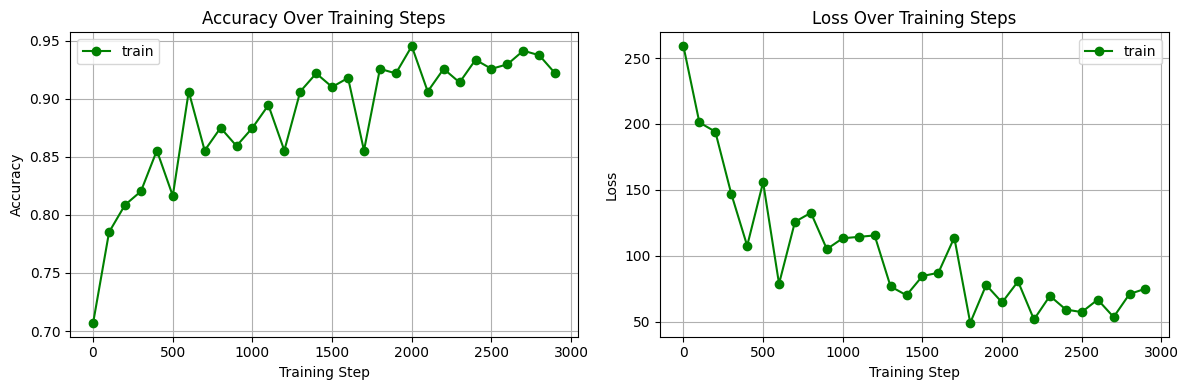

In [11]:
# Виведи графіки залежності зміни точності і втрат від кроку
# Якщо все зроблено правильно, то точність повинна зростати, а втрати зменшуватись


# Створення та налаштування графіків
plt.figure(figsize=(12, 4))

# Графік точності
plt.subplot(1, 2, 1)
plt.plot(range(1, len(accuracy_history) * display_step + 1, display_step), accuracy_history, marker='o', color="green", label='train')
plt.title('Accuracy Over Training Steps')
plt.legend()
plt.xlabel('Training Step')
plt.ylabel('Accuracy')
plt.grid()

# Графік втрат
plt.subplot(1, 2, 2)
plt.plot(range(1, len(loss_history) * display_step + 1, display_step), loss_history, marker='o', color="green", label='train')
plt.title('Loss Over Training Steps')
plt.legend()
plt.xlabel('Training Step')
plt.ylabel('Loss')
plt.grid()

# Відображення графіків
plt.tight_layout()
plt.show()

In [17]:
# Обчисли точність навченої нейромережі

# Оцінюю модель на тестових даних
pred = neural_net(x_test)
loss = cross_entropy(pred, y_test)
acrcy = accuracy(pred, y_test)
print(f"Точність на тестових даних: {acrcy * 100:.2f}%")

# # Розраховую Precision та Recall
# y_true = np.argmax(y_test, axis=1)
# y_pred = np.argmax(pred, axis=1)
# precision = precision_score(y_true, pred, average='weighted')
# recall = recall_score(y_true, pred, average='weighted')
# print(f"Precision: {precision:.2f}")
# print(f"Recall: {recall:.2f}")

Точність на тестових даних: 90.55%


In [18]:


# Розрахунок матриці сплутаності
conf_matrix = confusion_matrix(y_test, tf.argmax(pred, axis=1))

# Кількість класів
num_classes = len(conf_matrix)

# Ініціалізація змінних для підрахунку TP, FP і FN для кожного класу
true_positives = [0] * num_classes
false_positives = [0] * num_classes
false_negatives = [0] * num_classes

# Обчислення TP, FP і FN для кожного класу
for i in range(num_classes):
    true_positives[i] = conf_matrix[i, i]
    false_positives[i] = sum(conf_matrix[:, i]) - true_positives[i]
    false_negatives[i] = sum(conf_matrix[i, :]) - true_positives[i]

# Обчислення Precision і Recall для кожного класу
precision = [true_positives[i] / (true_positives[i] + false_positives[i]) for i in range(num_classes)]
recall = [true_positives[i] / (true_positives[i] + false_negatives[i]) for i in range(num_classes)]

# Обчислення середнього значення Precision (Macro-Averaging)
macro_average_precision = sum(precision) / num_classes

# Обчислення середнього значення Recall (Macro-Averaging)
macro_average_recall = sum(recall) / num_classes

# Обчислення Precision і Recall на основі сум TP, FP і FN (Micro-Averaging)
micro_average_precision = sum(true_positives) / (sum(true_positives) + sum(false_positives))
micro_average_recall = sum(true_positives) / (sum(true_positives) + sum(false_negatives))

print("Precision for each class:", precision)
print("Recall for each class:", recall)
print("Macro-Averaged Precision:", macro_average_precision)
print("Macro-Averaged Recall:", macro_average_recall)
print("Micro-Averaged Precision:", micro_average_precision)
print("Micro-Averaged Recall:", micro_average_recall)

Precision for each class: [0.9438775510204082, 0.9674868189806678, 0.871177015755329, 0.8622641509433963, 0.8953722334004024, 0.8862068965517241, 0.9256544502617801, 0.9076773566569485, 0.8879310344827587, 0.9017580144777663]
Recall for each class: [0.9438775510204082, 0.9700440528634361, 0.9108527131782945, 0.904950495049505, 0.9063136456211812, 0.8643497757847534, 0.9227557411273486, 0.9085603112840467, 0.8459958932238193, 0.8642220019821606]
Macro-Averaged Precision: 0.904940552253118
Macro-Averaged Recall: 0.9041922181134954
Micro-Averaged Precision: 0.9055
Micro-Averaged Recall: 0.9055


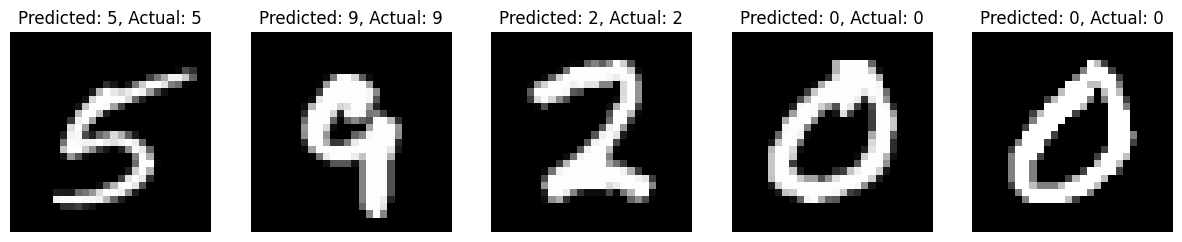

Accuracy on 5 test samples: 100.00%


In [31]:
# Протестуємо навчену нейромережу на 10 зображеннях. З тестової вибірки візьми 5
# випадкових зображень і передай їх у нейронну мережу.
# Виведи зображення та випиши поруч відповідь нейромережі.


import numpy as np
import matplotlib.pyplot as plt

# Виберіть 5 випадкових зображень з тестового набору даних MNIST
num_samples = 5
random_indices = np.random.choice(len(x_test), num_samples, replace=False)
test_images = x_test[random_indices]
test_labels = y_test[random_indices]

# Проходження кожного зображення через нейронну мережу і отримання передбачень
predictions = []
for image in test_images:
    prediction = neural_net(image[tf.newaxis, ...])  # Потрібно зробити розмірність (1, 28, 28, 1)
    predicted_class = tf.argmax(prediction, axis=1).numpy()[0]
    predictions.append(predicted_class)

# Виведення зображень та їх передбачень поруч
plt.figure(figsize=(15, 5))
for i in range(num_samples):
    plt.subplot(1, num_samples, i + 1)

    # Розгортайте зображення перед відображенням
    flattened_image = test_images[i].reshape(28, 28)

    plt.imshow(flattened_image, cmap='gray')
    plt.title(f"Predicted: {predictions[i]}, Actual: {test_labels[i]}")
    plt.axis('off')
plt.show()

# Підрахунок помилкових передбачень
incorrect_predictions = np.sum(np.array(predictions) != test_labels)
accuracy = 1.0 - (incorrect_predictions / num_samples)

print(f"Accuracy on {num_samples} test samples: {accuracy * 100:.2f}%")



# Зроби висновок про те, чи помиляється твоя нейронна мережа, і якщо так, то як часто?

Мережа помиляється майже у 10% прогнозів.

У моделі досить високі значення Precision для більшості класів, що означає, що модель добре визначає екземпляри класів.


Recall також має гарні значення для більшості класів, що означає, що модель ефективно знаходить багато екземплярів.


Значення Macro-Averaged Precision і Recall є близькими одне до одного, що вказує на рівномірну точність та виявленість на всіх класах.


Значення Micro-Averaged Precision і Recall також є високими, що вказує на загальну точність і виявлення моделі.


Загальною висновок є той, що модель класифікації працює добре для даного завдання і має гарні показники точності і виявлення на різних класах датасету.